In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from dtw_gi.dtw.backend import compute_dtw_path
from dtw_gi import dtw_gi
from dtw_gi import soft_dtw_gi
from data import make_one_folium, get_rot2d, set_fig_style, make_one_spiral, plot_trajectory


# Configuration
T = 80
noise_std = 0.01
angles = np.linspace(0.0, 2 * np.pi, 30)
n_runs = 20
device = "cpu"

set_fig_style(font_size=14)

np.random.seed(0)


# Storage
dtw_costs = np.zeros((n_runs, len(angles)))
gi_costs = np.zeros((n_runs, len(angles)))
soft_gi_costs = np.zeros((n_runs, len(angles)))


# Main loop
for run in range(n_runs):
    # Fresh reference signal each run
    x = make_one_spiral(T, noise=noise_std)

    # Sweep angles
    for j, alpha in enumerate(angles):
        y = make_one_spiral(T, noise=noise_std)
        y = np.dot(y, get_rot2d(alpha))

        # DTW
        path, cost_dtw = compute_dtw_path(x, y)
        dtw_costs[run, j] = cost_dtw

        # DTW-GI
        res_gi = dtw_gi(
            x, y, max_iter=30
        )
        gi_costs[run, j] = res_gi.cost

        # softDTW-GI
        soft_cost = np.sqrt(soft_dtw_gi(
            x, y,
            gamma=0.01,
            max_iter=150,
            lr=0.01,
            normalize =True
        ).cost)
        soft_gi_costs[run, j] = soft_cost

        print(
        f"alpha={alpha:.2f} | "
        f"DTW={cost_dtw:.3f} | "
        f"DTW-GI={res_gi.cost:.3f} | "
        f"SoftDTW-GI={soft_cost:.3f}"
    )

    print(f"[Run {run+1:02d}/{n_runs}] completed")



In [25]:
# Normalization
dtw_mean = dtw_costs[:13,:].mean(axis=0)
gi_mean = gi_costs[:13,:].mean(axis=0)
soft_gi_mean = soft_gi_costs[:13,:].mean(axis=0)

dtw_mean /= dtw_mean[0]
gi_mean /= gi_mean[0]
soft_gi_mean /= soft_gi_mean[0]

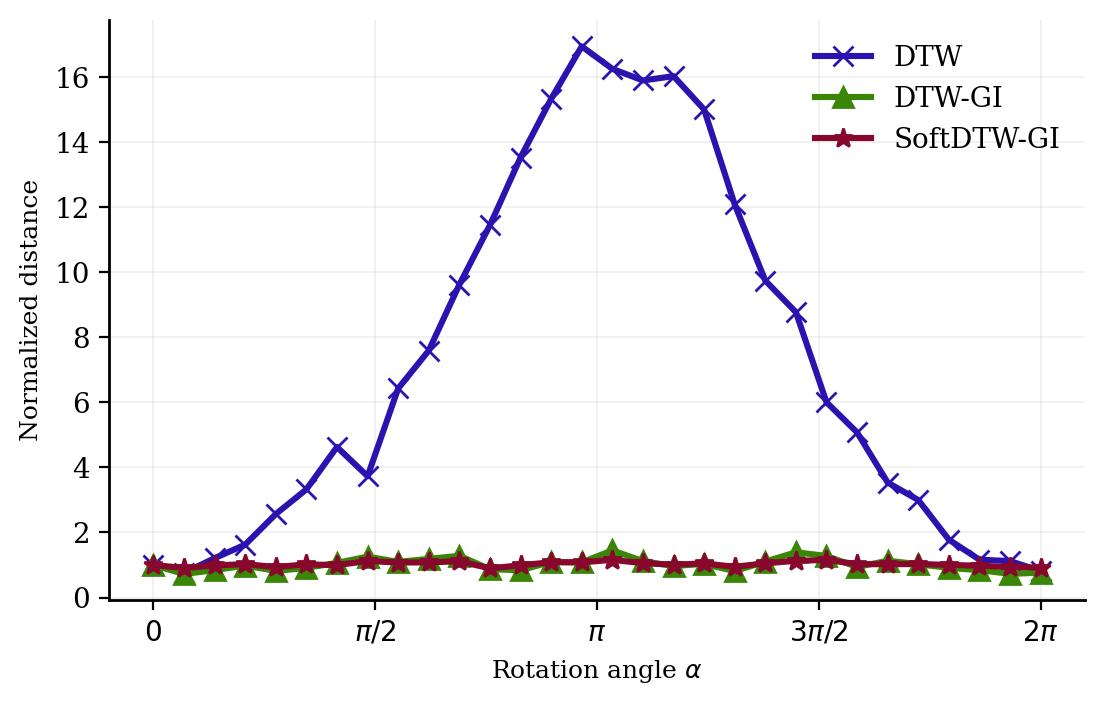

In [28]:
plt.rcParams.update({
    "savefig.dpi": 300,
    "figure.dpi": 200,
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(5.4, 3.4))  

ax.plot(
    angles,
    dtw_mean,
    color="#2b13af",
    linewidth=2.2,
    marker="x",
    markersize=7,
    label="DTW",
)

ax.plot(
    angles,
    gi_mean,
    color="#3a8707",
    linewidth=2.2,
    marker="^",
    markersize=7,
    label="DTW-GI",
)

ax.plot(
    angles,
    soft_gi_mean,
    color="#87072d",
    linewidth=2.2,
    marker="*",
    markersize=7,
    label="SoftDTW-GI",
)

ax.set_xlabel(r"Rotation angle $\alpha$")
ax.set_ylabel("Normalized distance")

ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(
    [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
)

ax.grid(True, alpha=0.2, linewidth=0.6)
ax.legend(frameon=False, loc="upper right")

plt.tight_layout(pad=0.3)
plt.show()
